# Trade Powerpoint -- Collect Data

In [1]:
import requests
import json
import config
import pandas as pd
import time
%matplotlib inline

#external files used: 'sitc29614digit.xlsx' from https://www.census.gov/foreign-trade/statistics/country/sitc/index.html

### Employment Index

In [2]:
url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'
key = '?registrationkey={}'.format(config.bls_key)
headers = {'Content-type': 'application/json'}
series_dict = {
    'Total_emp': 'CES0000000001',
    'Manf_emp': 'CES3000000001',
#    'Auto_emp': 'CES3133600101',
#    'Auto_wages': 'CES3133600108',
#    'CPI-W': 'CWSR0000SA0'
}
inv_map = {v: k for k, v in series_dict.iteritems()}
series_list = series_dict.values()  # Take just the series codes as a list

date_list = [("1970", "1978"),("1979", "1988"),("1989", "1998"), ("1999", "2008"), ("2009", "2017")]
df = pd.DataFrame()

In [3]:
for start, end in date_list:
    data = json.dumps({"seriesid":series_list, "startyear":start, "endyear":end})
    json_data = requests.post('{}{}'.format(url, key), headers=headers, data=data).json()
    # Store the relevant information in a dictionay and combine into a pandas dataframe
    d = {}
    for series in json_data['Results']['series']:
        seriesId = series['seriesID']
        d[seriesId] = pd.DataFrame(series['data'])
        if len(series['data']) > 0:
            # Convert BLS API dates to readable format (YYYY-MM-DD)
            d[seriesId]['date'] = pd.to_datetime(d[seriesId]['period'] + ' ' + d[seriesId]['year'])
            # Keep only date and series values
            d[seriesId] = d[seriesId].sort_values(by='date')[['date', 'value']].set_index('date')
            # Rename and round
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId]).astype(float)
        else:
            d[seriesId]['date'] = pd.Series()
            d[seriesId]['value'] = pd.Series()
            d[seriesId] = d[seriesId]['value'].rename(inv_map[seriesId])
    df = df.append(pd.concat([d[series_list[x]] for x in range(len(d))], axis=1))

In [5]:
df['MFN_share'] = df['Manf_emp'] / df['Total_emp'] * 100

In [6]:
df.to_csv('Manufacturing_share_jobs_1970.csv')

In [4]:
for series in df.keys():
    df[series+'_ix'] = df[series] / df.loc['1990-01-01'][series] * 100

### Linear trend projecting auto employment

In [5]:
df['auto_share'] = df['Auto_emp'] / df['Total_emp'] * 100

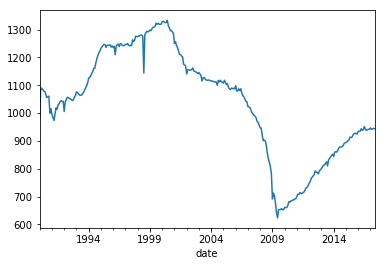

In [6]:
df['Auto_emp'].plot()

In [7]:
numbers = df['Auto_emp'].pct_change()[-12:].values
print reduce(lambda x, y: x*y, numbers)**(1.0/len(numbers))

0.00304833305878


In [8]:
df['Auto_emp'].diff()[1:].values.sum() + 1

-30.799999999999955

### Real Wages - Auto Workers

In [9]:
df['Auto_real_wage'] = df['Auto_wages'].multiply(df.loc['2017-01-01', 'CPI-W']).divide(df['CPI-W'])

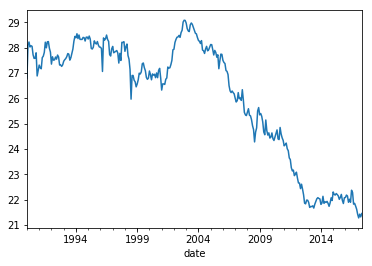

In [10]:
df['Auto_real_wage'].plot()

### Exchange Rates

In [11]:
base = 'https://api.stlouisfed.org/fred/series/observations?series_id='

s_list = {
    'CAD-USD': 'EXCAUS',
    'MXN-USD': 'EXMXUS',
    'Broad Index': 'TWEXBPA',
    'Canada CPI': 'CANCPIALLMINMEI',
    'Mexico CPI': 'MEXCPIALLMINMEI',
    'USA CPI': 'CPIAUCSL'
}

dates = '&observation_start=1990-01-01'
key = '&api_key={}'.format(config.fred_key)
ftype = '&file_type=json'

d = {}
for k, v in s_list.iteritems():
    url = '{}{}{}{}{}'.format(base, v, dates, key, ftype)
    fx = pd.DataFrame(requests.get(url).json()['observations'])
    fx = fx.set_index(pd.to_datetime(fx['date']))
    fx = fx.rename(columns={'value': v})[v].astype(float)
    d[v] = fx
fx = pd.DataFrame(d)

In [12]:
fx['MXN-USD_real'] = fx['EXMXUS'].multiply(fx['MEXCPIALLMINMEI']).divide(fx['CPIAUCSL'])
fx['CAD-USD_real'] = fx['EXCAUS'].multiply(fx['CANCPIALLMINMEI']).divide(fx['CPIAUCSL'])
for series in ['TWEXBPA', 'MXN-USD_real', 'CAD-USD_real']:
    # Indexed to 1994
    fx[series+'_index'] = fx[series] / fx.loc['2000-01-01'][series] * 100

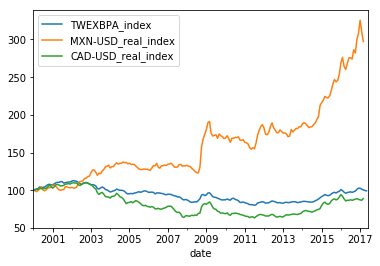

In [13]:
%matplotlib inline
fx[['TWEXBPA_index', 'MXN-USD_real_index', 'CAD-USD_real_index']][120:].plot()

### Bilateral Trade History
#### 1996-2014 Data from Census

In [14]:
th = pd.read_excel('sitc29614digit.xlsx')
th = th.drop(th.columns[[5]], axis=1)
th.rename(index=str, columns={'ExportsFASValueBasisYtdDec':'Export', 'GenImportsCIFValBasisYtdDec':'Import'}, inplace=True)

In [15]:
# World is 0, Canada is 1220, and Mexico is country code 2010:
countries = [0, 1220, 2010]

In [16]:
th_auto = th.loc[(th['CTY_CODE'].isin(countries)) & (th['SITC'].isin([78]))]
th_auto = th_auto.set_index(['Year', 'CTY_CODE'])[['Export', 'Import']]
th_manu = th.loc[(th['CTY_CODE'].isin(countries)) & (th['SITC'].between(60, 89, inclusive=True))]
th_manu = th_manu.groupby(['Year', 'CTY_CODE']).sum()[['Export', 'Import']]

#### 2015-Present Data from Census

In [17]:
th2 = pd.read_excel('sitc215presdigit.xlsx')
th2 = th2.drop(th2.columns[[5]], axis=1)
th2.rename(index=str, columns={'ExportsFASValueBasisYtdDec':'Export', 'GenImportsCIFValBasisYtdDec':'Import'}, inplace=True)
th2_auto = th2.loc[(th2['CTY_CODE'].isin(countries)) & (th2['SITC'].isin([78]))]
th2_auto = th2_auto.set_index(['Year', 'CTY_CODE'])[['Export', 'Import']]
th2_manu = th2.loc[(th2['CTY_CODE'].isin(countries)) & (th2['SITC'].between(60, 89, inclusive=True))]
th2_manu = th2_manu.groupby(['Year', 'CTY_CODE']).sum()[['Export', 'Import']]

In [18]:
th_auto = th_auto.append(th2_auto)
th_manu = th_manu.append(th2_manu)

#### Pre-1996 Data from Comtrade

In [19]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in xrange(0, len(seq), size))
dates = [str(year) for year in range(1981,1996)]
d = {}
url = 'http://comtrade.un.org/api/get?max=50000&type=C&freq=A&px=S2'
for n in chunker(dates, 5):
    param = '&ps={}&r=842&p=484%2C124%2C0&rg=2%2C1&cc=6%2C7%2C8%2C78'.format('%2C'.join(n))
    data = requests.get('{}{}'.format(url, param)).json()
    d[n[0]] = pd.DataFrame(data['dataset'])[['yr', 'ptCode', 'TradeValue', 'rgDesc', 'cmdCode']]
    time.sleep(5)

In [20]:
ct = pd.concat(d.values())
ct.rename(index=str, columns={'yr':'Year', 'ptCode':'CTY_CODE'}, inplace=True)
ct['CTY_CODE'] = ct['CTY_CODE'].replace(124, 1220).replace(484, 2010)
ct_auto = ct.loc[ct['cmdCode'] == '78'].pivot_table('TradeValue', ['Year', 'CTY_CODE'], 'rgDesc')
ct_manu = ct.loc[ct['cmdCode'].isin(['6','7','8'])].pivot_table('TradeValue', ['Year', 'CTY_CODE', 'cmdCode'], 'rgDesc')

#### Combined trade data

In [21]:
tr_auto = ct_auto.append(th_auto).unstack()
tr_manu = ct_manu.reset_index().groupby(['Year', 'CTY_CODE']).sum().append(th_manu).unstack()

### Calculate Rest of World

In [22]:
for flow in ['Export', 'Import']:
    tr_auto.loc[:,(flow,'ROW')] = tr_auto[flow][0] - tr_auto[flow][1220] - tr_auto[flow][2010]
    tr_manu.loc[:,(flow,'ROW')] = tr_manu[flow][0] - tr_manu[flow][1220] - tr_manu[flow][2010]

#### Convert to 2015 dollars

In [23]:
url = 'https://www.bls.gov/cpi/researchseries_allitems.xlsx'
prices = pd.read_excel(url, header=5).set_index('Year').unstack().loc['AVG'].dropna()

In [36]:
d = {}
d2 = {}
for year in range (1981, 2017):
    d[year] = tr_auto.loc[year] * prices.loc[2016] / prices.loc[year] / 1000000000
    d2[year] = tr_manu.loc[year] * prices.loc[2016] / prices.loc[year] / 1000000000
tr_auto_real = pd.concat(d).unstack().unstack()
tr_manu_real = pd.concat(d2).unstack().unstack()

### Calculate total trade (X+M) and Balance (X-M)

In [38]:
for sheet in [tr_auto_real, tr_manu_real]:
    for area in [0, 1220, 2010, 'ROW']:
        sheet.loc[:,(area,'Total')] = sheet[area]['Export'] + sheet[area]['Import']
        sheet.loc[:,(area,'Balance')] = sheet[area]['Export'] - sheet[area]['Import']

### Create xlsx file

In [42]:
writer = pd.ExcelWriter('trade_ppt_data3.xlsx')

In [43]:
tr_auto.drop(2017).to_excel(writer, sheet_name='auto trade')
tr_manu.drop(2017).to_excel(writer, sheet_name='manu trade')
tr_auto_real.to_excel(writer, sheet_name='auto trade real')
tr_manu_real.to_excel(writer, sheet_name='manu trade real')
fx.to_excel(writer, sheet_name='fx')
df.to_excel(writer, sheet_name='bls')